In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading in Raw Labeled Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fall 2022/Data144/Final Project 3/lyric_data.csv')
df.head()

,Lyric,Hip Hop,Pop,Rock
0,I could feel at the time. There was no way of ...,0,0,1
1,"Take me now, baby, here as I am. Hold me close...",0,0,1
2,These are. These are days you'll remember. Nev...,0,0,1
3,"A lie to say, ""O my mountain has coal veins an...",0,0,1
4,Trudging slowly over wet sand. Back to the ben...,0,0,1


In [ ]:
num_songs = len(df)
num_hiphop = len(df[df['Hip Hop'] == 1])
num_pop = len(df[df['Pop'] == 1])
num_rock = len(df[df['Rock'] == 1])
print(num_songs, "songs in total.")
print("Hip Hop Songs:", num_hiphop, "songs", round(num_hiphop / num_songs * 100, 2), "% of total.")
print("Pop Songs:", num_pop, "songs", round(num_pop / num_songs * 100, 2), "% of total.")
print("Rock Songs:", num_rock, "songs", round(num_rock / num_songs * 100, 2), "% of total.")

86507 songs in total.
Hip Hop Songs: 13590 songs 15.71 % of total.
Pop Songs: 25502 songs 29.48 % of total.
Rock Songs: 47415 songs 54.81 % of total.


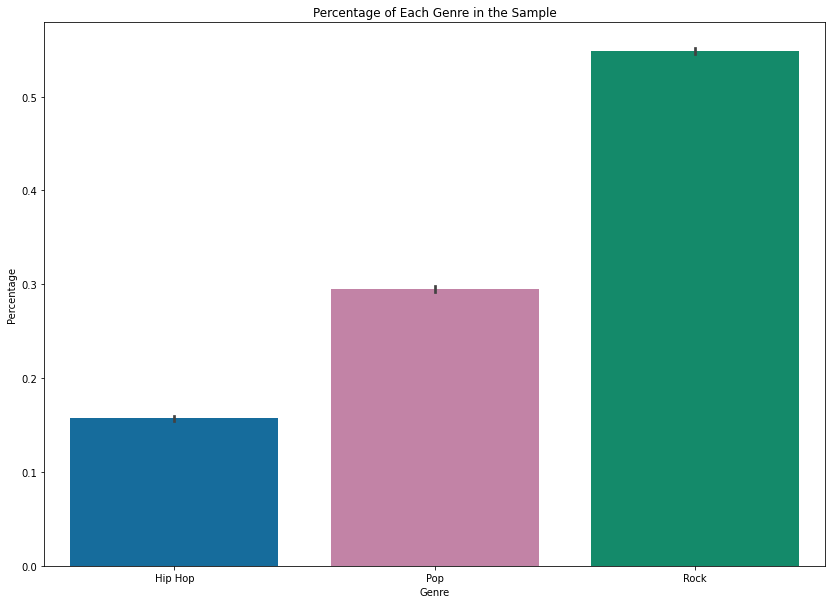

In [ ]:
genrePalette = {'Pop': "#cc79a7", 'Hip Hop': "#0072b2",'Rock': "#009e73"}

plt.figure(figsize=(14, 10));
sns.barplot(data=df, palette = genrePalette)
plt.title('Percentage of Each Genre in the Sample')
plt.xlabel('Genre')
plt.ylabel('Percentage');

# Downsample to ~8.8% of data and roughly even distribution of genres

In [ ]:
df = df.sample(frac=0.2, random_state=42)

hiphop_df = df[df['Hip Hop'] == 1]
pop_df = df[df['Pop'] == 1]
pop_df = pop_df.sample(frac=0.5, random_state=42)
rock_df = df[df['Rock'] == 1]
rock_df = rock_df.sample(frac=0.25, random_state=42)
df = hiphop_df.append(pop_df).append(rock_df)

num_songs = len(df)
num_hiphop = len(df[df['Hip Hop'] == 1])
num_pop = len(df[df['Pop'] == 1])
num_rock = len(df[df['Rock'] == 1])
print(num_songs, "songs in sample.")
print("Hip Hop Songs:", num_hiphop, "songs", round(num_hiphop / num_songs * 100, 2), "% of sample.")
print("Pop Songs:", num_pop, "songs", round(num_pop / num_songs * 100, 2), "% of sample.")
print("Rock Songs:", num_rock, "songs", round(num_rock / num_songs * 100, 2), "% of sample.")

7623 songs in sample.
Hip Hop Songs: 2711 songs 35.56 % of sample.
Pop Songs: 2530 songs 33.19 % of sample.
Rock Songs: 2382 songs 31.25 % of sample.


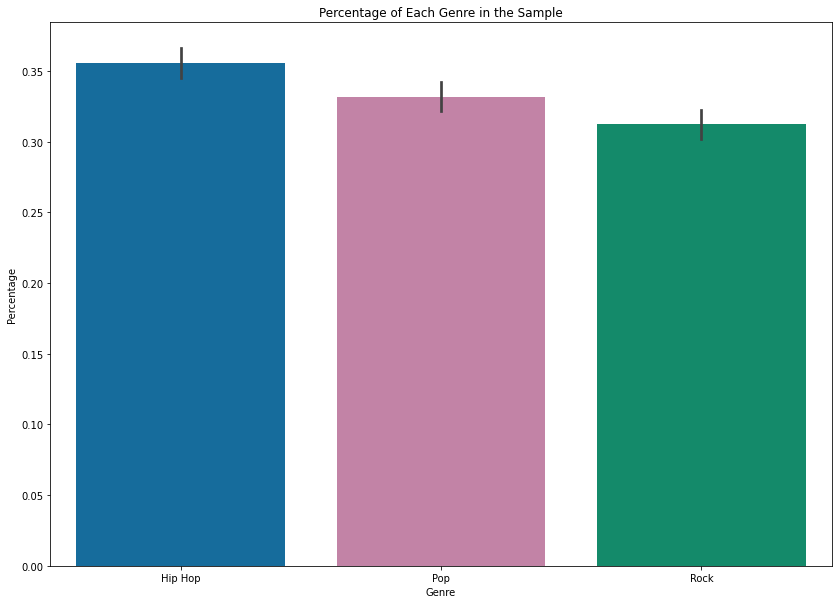

In [ ]:
plt.figure(figsize=(14, 10));
sns.barplot(data=df, palette=genrePalette)
plt.title('Percentage of Each Genre in the Sample')
plt.xlabel('Genre')
plt.ylabel('Percentage');

# Normalize Lyrics

1. Set to lowercase
2. Remove non-alphanumeric characters
3. Tokenize into lists

In [ ]:
df['Lyric'] = df['Lyric'].apply(lambda l: l.lower())
df['Lyric'] = df['Lyric'].apply(lambda l: re.sub(r'[^A-Za-z0-9 ]+', '', l))
df['Lyric'] = df['Lyric'].apply(lambda l: word_tokenize(l))
df

,Lyric,Hip Hop,Pop,Rock
59806,"[verse, 1, when, i, looked, over, my, shoulder...",1,0,0
59665,"[woman, its, another, fuckin, party, same, shi...",1,0,0
64752,"[i, said, the, top, is, so, close, its, right,...",1,0,0
63438,"[damn, this, beat, is, so, sexyhoney, cocaine,...",1,0,0
63110,"[feat, busta, rhymes, 2pac, talkin, you, know,...",1,0,0
...,...,...,...,...
11293,"[josies, never, been, the, type, of, girl, to,...",0,0,1
43383,"[hey, im, driving, down, a, dusty, road, hey, ...",0,0,1
12986,"[divide, and, conquer, show, no, mercy, defile...",0,0,1
12296,"[acapulco, sleeping, in, the, bay, acapulco, w...",0,0,1


Length distribution

In [ ]:
song_lengths = df['Lyric'].apply(lambda l: len(l))
hiphop_lengths = df[df['Hip Hop'] == 1]['Lyric'].apply(lambda l: len(l))
pop_lengths = df[df['Pop'] == 1]['Lyric'].apply(lambda l: len(l))
rock_lengths = df[df['Rock'] == 1]['Lyric'].apply(lambda l: len(l))

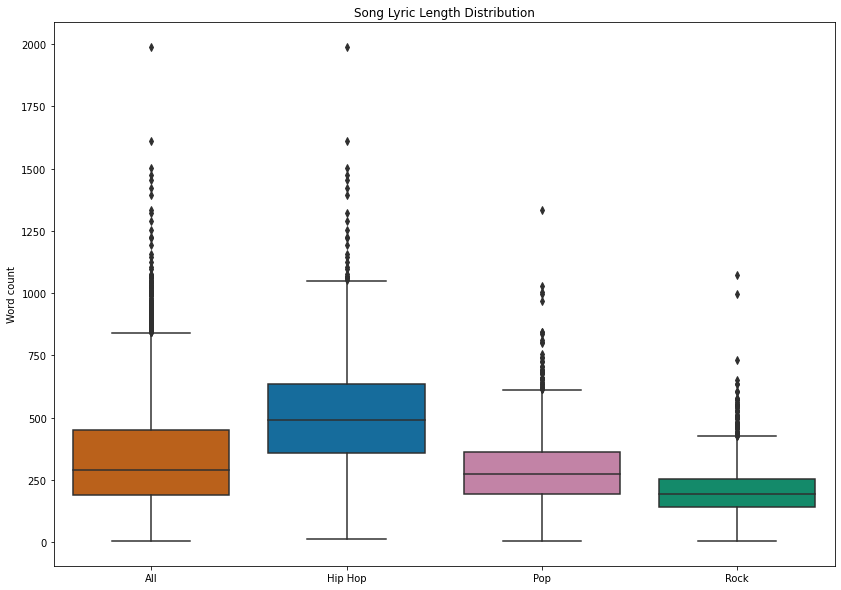

In [ ]:
plt.figure(figsize=(14, 10))
combined_lengths = pd.DataFrame({'All': song_lengths, 'Hip Hop': hiphop_lengths, 'Pop': pop_lengths, 'Rock': rock_lengths})
boxPalette = {'Pop': "#cc79a7", 'Hip Hop': "#0072b2",'Rock': "#009e73", 'All': "#d55e00"}
sns.boxplot(data=combined_lengths, palette=boxPalette)
plt.title("Song Lyric Length Distribution")
plt.ylabel("Word count");

# Remove non-English words

In [ ]:
english_words = set(nltk.corpus.words.words())

def filter_non_words(tokenized_lst):
  return [word for word in tokenized_lst if word in english_words]

df['Lyric'] = df['Lyric'].apply(filter_non_words)
df

,Lyric,Hip Hop,Pop,Rock
59806,"[verse, when, i, over, my, shoulder, it, got, ...",1,0,0
59665,"[woman, its, another, party, same, turn, this,...",1,0,0
64752,"[i, said, the, top, is, so, close, its, right,...",1,0,0
63438,"[damn, this, beat, is, so, cocaine, yellow, bi...",1,0,0
63110,"[feat, you, know, what, gang, violence, is, mo...",1,0,0
...,...,...,...,...
11293,"[never, been, the, type, of, girl, to, stop, a...",0,0,1
43383,"[hey, driving, down, a, dusty, road, hey, got,...",0,0,1
12986,"[divide, and, conquer, show, no, mercy, defile...",0,0,1
12296,"[acapulco, sleeping, in, the, bay, acapulco, w...",0,0,1


# Keep nouns, adjectives, verbs using position tagging

In [ ]:
'''
keep = ['NN', 'ADJ', 'VB']
def keep_noun_verb_adj(tokenized_lst):
  pos_tagged = pos_tag(tokenized_lst)
  lst = []
  for word, tag in pos_tagged:
    if tag in keep:
      lst.append(word)
  return lst

df['Lyric'] = df['Lyric'].apply(keep_noun_verb_adj)
df
'''

"\nkeep = ['NN', 'ADJ', 'VB']\ndef keep_noun_verb_adj(tokenized_lst):\n  pos_tagged = pos_tag(tokenized_lst)\n  lst = []\n  for word, tag in pos_tagged:\n    if tag in keep:\n      lst.append(word)\n  return lst\n\ndf['Lyric'] = df['Lyric'].apply(keep_noun_verb_adj)\ndf\n"

# Filter out non-important stop words

In [ ]:
stop_words = set(stopwords.words('english'))
def remove_stop_words(tokenized_lst):
  return [word for word in tokenized_lst if not word in stop_words]

df['Lyric'] = df['Lyric'].apply(remove_stop_words)
df

,Lyric,Hip Hop,Pop,Rock
59806,"[verse, shoulder, got, little, bit, colder, li...",1,0,0
59665,"[woman, another, party, turn, trice, woman, ev...",1,0,0
64752,"[said, top, close, right, know, want, reach, a...",1,0,0
63438,"[damn, beat, cocaine, yellow, bitch, wear, gol...",1,0,0
63110,"[feat, know, gang, violence, mostly, people, d...",1,0,0
...,...,...,...,...
11293,"[never, type, girl, stop, think, like, hunting...",0,0,1
43383,"[hey, driving, dusty, road, hey, got, nowhere,...",0,0,1
12986,"[divide, conquer, show, mercy, defile, honor, ...",0,0,1
12296,"[acapulco, sleeping, bay, acapulco, wake, gree...",0,0,1


# Applying stemming

In [ ]:
ps = PorterStemmer()

def return_stemmed(tokenized_lst):
  return [ps.stem(word) for word in tokenized_lst]

df['Lyric'] = df['Lyric'].apply(return_stemmed)
df

,Lyric,Hip Hop,Pop,Rock
59806,"[vers, shoulder, got, littl, bit, colder, like...",1,0,0
59665,"[woman, anoth, parti, turn, trice, woman, ever...",1,0,0
64752,"[said, top, close, right, know, want, reach, a...",1,0,0
63438,"[damn, beat, cocain, yellow, bitch, wear, gold...",1,0,0
63110,"[feat, know, gang, violenc, mostli, peopl, don...",1,0,0
...,...,...,...,...
11293,"[never, type, girl, stop, think, like, hunt, l...",0,0,1
43383,"[hey, drive, dusti, road, hey, got, nowher, go...",0,0,1
12986,"[divid, conquer, show, merci, defil, honor, so...",0,0,1
12296,"[acapulco, sleep, bay, acapulco, wake, greet, ...",0,0,1


# Apply lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

def return_lemmatized(tokenized_lst):
  return [lemmatizer.lemmatize(word) for word in tokenized_lst]

df['Lyric'] = df['Lyric'].apply(return_lemmatized)
df

,Lyric,Hip Hop,Pop,Rock
59806,"[vers, shoulder, got, littl, bit, colder, like...",1,0,0
59665,"[woman, anoth, parti, turn, trice, woman, ever...",1,0,0
64752,"[said, top, close, right, know, want, reach, a...",1,0,0
63438,"[damn, beat, cocain, yellow, bitch, wear, gold...",1,0,0
63110,"[feat, know, gang, violenc, mostli, peopl, don...",1,0,0
...,...,...,...,...
11293,"[never, type, girl, stop, think, like, hunt, l...",0,0,1
43383,"[hey, drive, dusti, road, hey, got, nowher, go...",0,0,1
12986,"[divid, conquer, show, merci, defil, honor, so...",0,0,1
12296,"[acapulco, sleep, bay, acapulco, wake, greet, ...",0,0,1


Final length distribution

In [ ]:
song_lengths = df['Lyric'].apply(lambda l: len(l))
hiphop_lengths = df[df['Hip Hop'] == 1]['Lyric'].apply(lambda l: len(l))
pop_lengths = df[df['Pop'] == 1]['Lyric'].apply(lambda l: len(l))
rock_lengths = df[df['Rock'] == 1]['Lyric'].apply(lambda l: len(l))

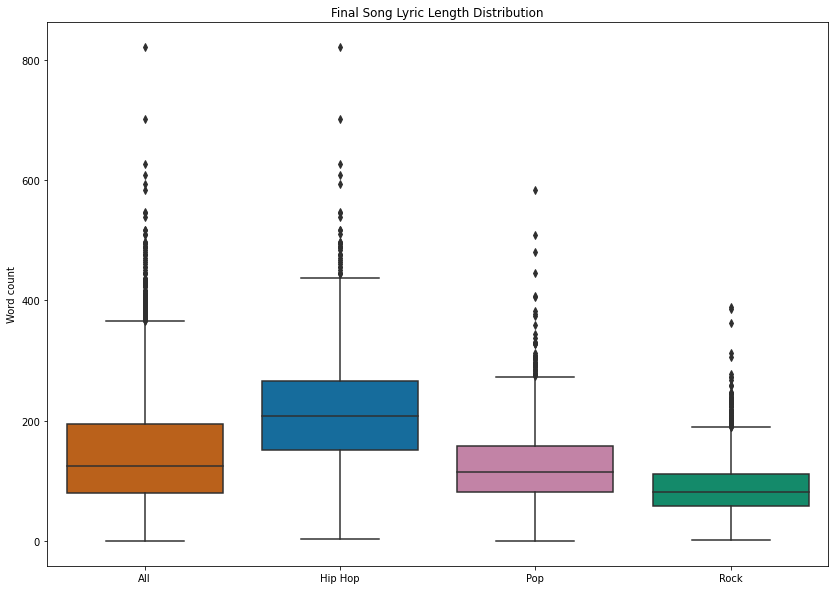

In [ ]:
plt.figure(figsize=(14, 10))
final_comb_lengths = pd.DataFrame({'All': song_lengths, 'Hip Hop': hiphop_lengths, 'Pop': pop_lengths, 'Rock': rock_lengths})
sns.boxplot(data=final_comb_lengths, palette=boxPalette)
plt.title("Final Song Lyric Length Distribution")
plt.ylabel("Word count");

# TF-IDF Vectorization


Split data into X and y components

In [ ]:
y = df[['Rock', 'Pop', 'Hip Hop']]
y['Pop'] = y['Pop'].apply(lambda x: 2 if x == 1 else 0)
y['Rock'] = y['Rock'].apply(lambda x: 3 if x == 1 else 0)
y['Genre'] = y['Pop'] + y['Hip Hop'] + y['Rock'] - 1
y = y.drop(columns=['Hip Hop', 'Pop', 'Rock'])
y # 0 = Hip Hop, 1 = Pop, 2 = Rock

,Genre
59806,0
59665,0
64752,0
63438,0
63110,0
...,...
11293,2
43383,2
12986,2
12296,2


In [ ]:
X = df['Lyric'].apply(lambda l: ' '.join(l)).to_frame().T
X

,59806,59665,64752,63438,63110,62354,62903,58544,63512,62482,...,3342,28888,25913,28420,49081,11293,43383,12986,12296,30910
Lyric,vers shoulder got littl bit colder like lost l...,woman anoth parti turn trice woman everyday co...,said top close right know want reach air littl...,damn beat cocain yellow bitch wear gold new bi...,feat know gang violenc mostli peopl dont want ...,kelli hope got card caus aint get unless ya st...,search black oh yeah black wit straight doubt ...,first vers murder bitch sister bitch bout get ...,probabl let know wasnt seriou jump wan na hit ...,bite dust trust anyth better bite dust realli ...,...,take littl walk worst come saw look like never...,live citi sleepless peopl know wont go far out...,doctor hous tonight there wrong could make rig...,travel etern look mind feel upon hidden sign s...,becom away use see differ way point view lost ...,never type girl stop think like hunt leav feel...,hey drive dusti road hey got nowher go hey pla...,divid conquer show merci defil honor sow disco...,acapulco sleep bay acapulco wake greet day tim...,say dead gone ye know wrong cut slash knife wo...


Applying TF-IDF vectorization

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
doc_vec = tfidf_vectorizer.fit_transform(X.iloc[0])
X2 = pd.DataFrame(doc_vec.toarray().transpose(), index=tfidf_vectorizer.get_feature_names())
X2.columns = X.columns
X2 = X2.T
X2

,aa,aback,abandon,abdomen,abdomin,abduct,aberr,abi,abid,abigail,...,zigzag,zimbabw,zing,zip,zipper,zodiac,zombi,zone,zoo,zoom
59806,0.0,0.0,0.08278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
59665,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64752,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028258
63438,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
63110,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11293,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
43383,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12986,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12296,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# Apply KMeans clustering (unsupervised)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X2)

Use TSNE dimensionality reduction to visualize data

In [ ]:
data_embed = TSNE(n_components=2, perplexity=50, verbose=2, n_iter=600, method='barnes_hut', random_state=10).fit_transform(X2)
viz_df = pd.DataFrame(data_embed[:,:2], columns=['x','y'])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7623 samples in 0.088s...
[t-SNE] Computed neighbors for 7623 samples in 24.922s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7623
[t-SNE] Computed conditional probabilities for sample 2000 / 7623
[t-SNE] Computed conditional probabilities for sample 3000 / 7623
[t-SNE] Computed conditional probabilities for sample 4000 / 7623
[t-SNE] Computed conditional probabilities for sample 5000 / 7623
[t-SNE] Computed conditional probabilities for sample 6000 / 7623
[t-SNE] Computed conditional probabilities for sample 7000 / 7623
[t-SNE] Computed conditional probabilities for sample 7623 / 7623
[t-SNE] Mean sigma: 0.392944
[t-SNE] Computed conditional probabilities in 0.719s
[t-SNE] Iteration 50: error = 106.5102386, gradient norm = 0.1050464 (50 iterations in 6.566s)
[t-SNE] Iteration 100: error = 120.3742905, gradient norm = 0.0078870 (50 iterations in 7.147s)
[t-SNE] Iteration 150: error = 124.6065979, gradient nor

In [ ]:
viz_df.set_index(X2.index, inplace=True)
viz_df['Labels'] = kmeans.labels_
viz_df = pd.concat([viz_df, y], axis=1)
viz_df.head()

,x,y,Labels,Genre
59806,-34.329460,5.894404,2,0
59665,18.002754,25.189892,2,0
64752,20.880186,8.235972,2,0
63438,15.583726,-16.618874,1,0
63110,36.430538,-3.099713,1,0


In [ ]:
viz_fix = viz_df.copy()
viz_fix.loc[viz_fix['Labels'] == 0, 'Labels'] = 'Pop'
viz_fix.loc[viz_fix['Labels'] == 1, 'Labels'] = 'Hip Hop'
viz_fix.loc[viz_fix['Labels'] == 2, 'Labels'] = 'Rock'
viz_fix.loc[viz_fix['Genre'] == 0, 'Genre'] = 'Hip Hop'
viz_fix.loc[viz_fix['Genre'] == 1, 'Genre'] = 'Pop'
viz_fix.loc[viz_fix['Genre'] == 2, 'Genre'] = 'Rock'
viz_fix.head()

,x,y,Labels,Genre
59806,-34.329460,5.894404,Rock,Hip Hop
59665,18.002754,25.189892,Rock,Hip Hop
64752,20.880186,8.235972,Rock,Hip Hop
63438,15.583726,-16.618874,Hip Hop,Hip Hop
63110,36.430538,-3.099713,Hip Hop,Hip Hop


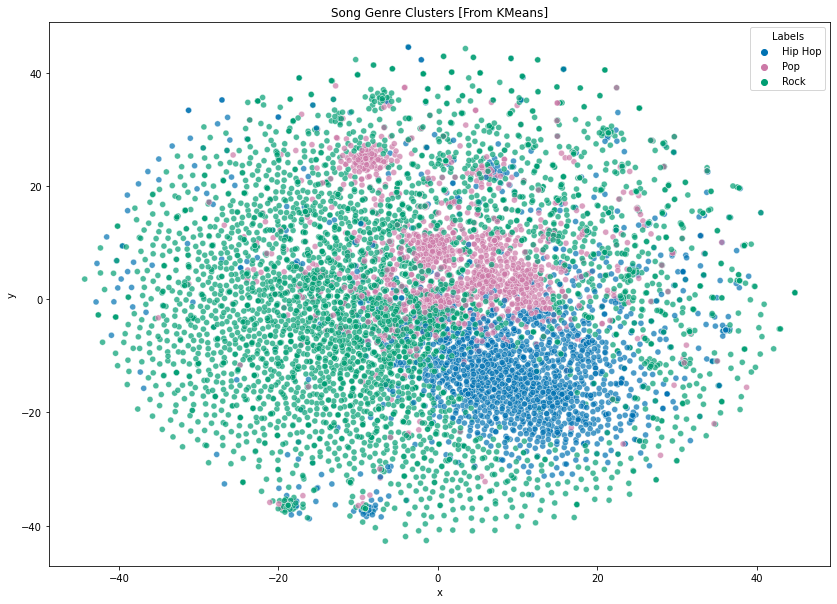

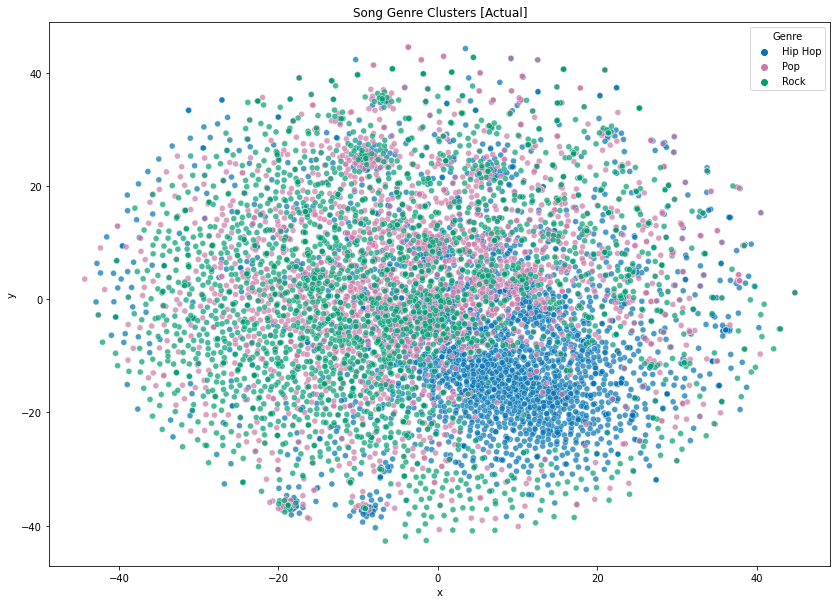

In [ ]:
plt.figure(figsize=(14, 10))
sns.scatterplot(data = viz_fix, x = 'x', y = 'y', hue='Labels', palette=genrePalette, hue_order=['Hip Hop', 'Pop', 'Rock'], alpha=.7)
plt.title('Song Genre Clusters [From KMeans]')
plt.show();


plt.figure(figsize=(14, 10))
sns.scatterplot(data = viz_fix, x='x', y='y', hue='Genre', palette=genrePalette, hue_order=['Hip Hop', 'Pop', 'Rock'], alpha=.7)
plt.title('Song Genre Clusters [Actual]')
plt.show();

# Analysis from KMeans clustering results

In [ ]:
analysis_df = X2.copy()
analysis_df['Labels'] = kmeans.labels_
label_0_df = analysis_df[analysis_df['Labels'] == 0].drop(columns=['Labels'])
label_1_df = analysis_df[analysis_df['Labels'] == 1].drop(columns=['Labels'])
label_2_df = analysis_df[analysis_df['Labels'] == 2].drop(columns=['Labels'])
analysis_df = analysis_df.drop(columns=['Labels'])
keys = [x for x in X2.columns]

In [ ]:
print("Most important words for Label 0 (Pop) classification")
values = [round(label_0_df[col].sum()/len(label_0_df) * 100, 2) for col in label_0_df.columns]
top20 = []
for idx in np.argpartition(values, -20)[-20:]:
  top20.append([keys[idx], values[idx]])
top20 = sorted(top20, key=lambda x: x[1], reverse=True)
for key, val in top20:
  print("Importance of", val, "for word", key)

Most important words for Label 0 (Pop) classification
Importance of 11.67 for word love
Importance of 10.63 for word na
Importance of 8.91 for word oh
Importance of 7.69 for word babi
Importance of 7.13 for word dont
Importance of 6.28 for word wan
Importance of 6.17 for word know
Importance of 5.66 for word gon
Importance of 4.87 for word yeah
Importance of 4.26 for word want
Importance of 4.25 for word girl
Importance of 3.91 for word got
Importance of 3.9 for word go
Importance of 3.7 for word say
Importance of 3.62 for word like
Importance of 3.59 for word make
Importance of 3.41 for word feel
Importance of 3.32 for word let
Importance of 3.28 for word time
Importance of 3.28 for word cant


In [ ]:
print("Most important words for Label 1 (Hip Hop) classification")
values = [round(label_1_df[col].sum()/len(label_1_df) * 100, 2) for col in label_1_df.columns]
top20 = []
for idx in np.argpartition(values, -20)[-20:]:
  top20.append([keys[idx], values[idx]])
top20 = sorted(top20, key=lambda x: x[1], reverse=True)
for key, val in top20:
  print("Importance of", val, "for word", key)

Most important words for Label 1 (Hip Hop) classification
Importance of 9.1 for word got
Importance of 8.45 for word like
Importance of 7.71 for word get
Importance of 6.54 for word aint
Importance of 5.0 for word dont
Importance of 4.78 for word ya
Importance of 4.57 for word know
Importance of 4.13 for word bitch
Importance of 4.0 for word back
Importance of 3.75 for word em
Importance of 3.62 for word yeah
Importance of 3.57 for word go
Importance of 3.56 for word caus
Importance of 3.36 for word money
Importance of 3.29 for word choru
Importance of 3.26 for word man
Importance of 3.2 for word that
Importance of 3.14 for word yo
Importance of 3.08 for word ta
Importance of 3.08 for word see


In [ ]:
print("Most important words for Label 2 (Rock) classification")
values = [round(label_2_df[col].sum()/len(label_2_df) * 100, 2) for col in label_2_df.columns]
top20 = []
for idx in np.argpartition(values, -20)[-20:]:
  top20.append([keys[idx], values[idx]])
top20 = sorted(top20, key=lambda x: x[1], reverse=True)
for key, val in top20:
  print("Importance of", val, "for word", key)

Most important words for Label 2 (Rock) classification
Importance of 2.89 for word know
Importance of 2.89 for word dont
Importance of 2.6 for word love
Importance of 2.48 for word like
Importance of 2.38 for word time
Importance of 2.36 for word go
Importance of 2.29 for word come
Importance of 2.22 for word never
Importance of 2.19 for word feel
Importance of 2.1 for word away
Importance of 2.06 for word one
Importance of 2.05 for word see
Importance of 2.03 for word cant
Importance of 1.99 for word oh
Importance of 1.97 for word way
Importance of 1.85 for word ill
Importance of 1.85 for word heart
Importance of 1.82 for word got
Importance of 1.81 for word day
Importance of 1.81 for word say


In [ ]:
results = pd.DataFrame(zip(y['Genre'], kmeans.labels_), columns=['Actual', 'Predicted'])

hiphop_results = results[results['Actual'] == 0]
hiphop_accuracy = sum(hiphop_results['Predicted'] == 1) / len(hiphop_results) * 100
print("Accuracy of Hip Hop:", round(hiphop_accuracy, 2))

pop_results = results[results['Actual'] == 1]
pop_accuracy = sum(pop_results['Predicted'] == 0) / len(pop_results) * 100
print("Accuracy of Pop:", round(pop_accuracy, 2))

rock_results = results[results['Actual'] == 2]
rock_accuracy = sum(rock_results['Predicted'] == 2) / len(rock_results) * 100
print("Accuracy of Rock:", round(rock_accuracy, 2))

weighted_accuracy = hiphop_accuracy * len(hiphop_results) / len(results) + pop_accuracy * len(pop_results) / len(results) + rock_accuracy * len(rock_results) / len(results) 
print("Overall accuracy:", round(weighted_accuracy, 2))

Accuracy of Hip Hop: 58.1
Accuracy of Pop: 28.54
Accuracy of Rock: 83.42
Overall accuracy: 56.2


# Trying unknown songs

In [ ]:
model_corpus = [x for x in X2.columns]

def filter_non_corpus(tokenized_lst):
  return [word for word in tokenized_lst if word in model_corpus]

def clean_new_song(song):
  song = song.lower()
  song = re.sub(r'[^A-Za-z0-9 ]+', '', song)
  song_words = word_tokenize(song)
  song_words = filter_non_corpus(song_words)
  song_words = filter_non_words(song_words)
  #song_words = keep_noun_verb_adj(song_words)
  song_words = remove_stop_words(song_words)
  song_words = return_stemmed(song_words)
  song_words = return_lemmatized(song_words)
  return ' '.join(song_words)

In [ ]:
#@title Hip Hop Song Lyrics
song1 = "Yeah\
(I'm workin' on dyin')\
I'm upset\
Fifty thousand on my head, it's disrespect\
So offended that I had to double check\
I'ma always take the money over sex\
That's why they need me out the way, what you expect?\
Got a lot of blood and it's cold\
They keep tryna' get me for my soul\
Thankful for the women that I know\
Can't go fifty-fifty with no hoe\
Every month\
I'm supposed to pay her bills and get her what she want\
I still got like seven years of doin' what I want\
My dad still got child support from 1991\
Outta town, people love to pop a lot of shit then come around\
Word to Flacko Jodye, he done seen us put it down\
Niggas askin' if I'm cool\
I'm upset\
Hunnid thousand on my head, it's disrespect (Disrespect)\
So offended that I had to double check\
You tryna check?\
This is real life, niggas think we playin' chess\
So what's next?\
Jump up out the bed like I'm possessed\
I go out on tour and I say I'm drinkin' less\
End up gettin' loose and gettin' pictures from my ex\
SMS, triple X\
That's the only time I ever shoot below the neck (Skrr)\
Why you keep on shootin' if you know that nigga dead? (Skrr)\
That's the only kind of shit that gets you some respect\
Got a lot of blood and it's cold\
They keep tryna get me for my soul\
Thankful for the women that I know\
Can't go fifty-fifty with no hoe (Ayy, ayy)\
Every month\
She don't even love me, she just puttin' on a front\
She gon' try and settle outta court and make a run\
Then gon' ask me how I'm doin'\
I'm upset\
Half a million on my head I can accept, yeah\
'Least it makes me feel like someone tried their best, yeah\
Want to waste a half a million, be my guest\
Made me wanna buy a vest and a TEC (Skrr)\
But I'm blessed, I just checked (Checked, checked)\
Hate me, never met me in the flesh (Flesh)\
Say she's got some things she gotta come here and collect\
That shit is in a box to the left, to the left\
Got a lot of blood and it's cold\
They keep tryna' get me for my soul (For my soul)\
Thankful for the women that I know (That I know)\
Can't go fifty-fifty with no hoe"

song2 = "We're gonna skate to one song and one song only\
(Ball so hard, motherfuckers wanna fine me)\
So I ball so hard, motherfuckers wanna fine me\
But first niggas gotta find me\
What's fifty grand to a motherfucker like me?\
Can you please remind me?\
Ball so hard, this shit crazy\
Y'all don't know that don't shit faze me\
The Nets could go 0 for 82\
When I look at you like This shit gravy!\
Ball so hard, this shit weird\
We ain't even 'posed to be here\
Ball so hard, but since we here\
It's only right that we'd be fair\
Psycho, I'm liable\
To go Michael, take your pick\
Jackson, Tyson, Jordan, Game 6\
Ball so hard, got a broke clock\
Rolex's that don't tick-tock\
Audemars that's losing time\
Hidden behind all these big rocks\
B-Ball so hard, I'm shocked too\
I'm supposed to be locked up too\
You escaped what I've escaped\
You'd be in Paris getting fucked up too\
B-Ball so hard, let's get faded\
Le Meurice for like six days\
Gold bottles, scold models\
Spillin' Ace on my sick J's\
B-Ball so hard, bitch, behave\
Just might let you meet Ye\
Chi-towns, D. Rose\
I'm moving the Nets, BK\
Ball so hard motherfuckers wanna fine me\
That shit cray\
That shit cray\
That shit cray\
B-Ball so hard motherfuckers wanna fine me\
That shit cray\
That shit cray\
That shit cray\
She said, Ye, can we get married at the mall?\
I said, Look, you need to crawl 'fore you ball\
Come and meet me in the bathroom stall\
And show me why you deserve to have it all\
Ball so hard\
That shit cray\
That shit cray\
Ain't it Jay?\
B-Ball so hard\
What she order?\
What she order?\
Fish fillet?\
B-Ball so hard\
Your whip so cold\
Whip so cold\
This old thing?\
Ball so hard\
Act like you'll never be around motherfuckers like this again\
Bougie girl, grab her hand\
Fuck that bitch, she 'on't wanna dance\
'Scuse my French, but I'm in France\
Hehe, I'm just sayin'\
Prince William's ain't do it right if you ask me\
'Cause I was him, I would've-\
Married Kate and Ashley\
What's Gucci, my nigga?\
What's Louis, my killa?\
What's drugs, my deala?\
What's that jacket, Margiela?\
Doctors say I'm the illest\
'Cause I'm suffering from realness\
Got my niggas in Paris and they going gorillas, heh?\
I don't even know what that means\
No one knows what it means\
But it's provocative\
No, it's not, it's gross\
Gets the people going\
Ball so hard motherfuckers wanna fine me\
B-Ball so hard motherfuckers wanna fine me\
You are now watching the throne\
Don't let me get in my zone\
Don't let me get in my zone\
Don't let me get in my zone\
These other niggas is lyin'\
Actin' like the summer ain't mine\
I got that hot bitch in my home\
You know how many hot bitches I own?\
Don't let me get in my zone\
Don't let me get in my zone\
Don't let me get in my zone\
Don't let me get in my zone\
The Stars is in the building\
They hands is to the ceiling\
I know I'm 'bout to kill it\
How you know I got that feeling?\
You are now watching the throne\
Don't let me into my zone\
Don't let me into my zone\
I'm definitely in my zone\
(Zone, zone, zone, zone, zone)\
(Zone, zone, zone, zone, zone)\
(Zone, zone, zone, zone, zone)\
(Zone, zone, zone, zone, zone)"

song3 = "You know, young rich niggas\
You know so we never really had no old money\
We got a whole lotta new money though, hah\
(If Young Metro don't trust you I'm gon' shoot ya)\
Raindrop, drop top (drop top)\
Smokin' on cookie in the hotbox (cookie)\
Fuckin' on your bitch she a thot, thot (thot)\
Cookin' up dope in the crockpot (pot)\
We came from nothin' to somethin' nigga (hey)\
I don't trust nobody grip the trigger (nobody)\
Call up the gang, and they come and get you (gang)\
Cry me a river, give you a tissue (hey)\
My bitch is bad and boujee (bad)\
Cookin' up dope with an Uzi (blaow)\
My niggas is savage, ruthless (savage)\
We got 30's and 100 rounds too (grrah)\
My bitch is bad and boujee (bad)\
Cookin' up dope with an Uzi (dope)\
My niggas is savage, ruthless (hey)\
We got 30's and 100 rounds too (glah)\
Offset, whoo, whoo, whoo, whoo, whoo!\
Rackings on rackings, got back-ends on back-ends\
I'm ridin' around in a coupe (coupe)\
I take your bitch right from you (You)\
Bitch I'm a dog, roof (grr)\
Beat the hoe walls loose (hey)\
Hop in the frog, whoo (skrt)\
I tell that bitch to come comfort me (comfort me)\
I swear these niggas is under me (hey)\
They hate and the devil keep jumpin' me (jumpin' me)\
Bankrolls on me keep me company (cash)\
We did the most, yeah\
Pull up in Ghosts, yeah (whoo)\
My diamonds a choker (glah)\
Holdin' the fire with no holster (blaow)\
Rick the Ruler, diamonds cooler (cooler)\
This a Rollie, not a Muller (hey)\
Dabbin' on 'em like the usual (dab)\
Magic with the brick, do voodoo (magic)\
Courtside with a bad bitch (bitch)\
Then I send the bitch through Uber (go)\
I'm young and rich and plus I'm bougie (hey)\
I'm not stupid so I keep the Uzi (rrah)\
Rackings on rackings, got back-ends on back-ends\
So my money makin' my back ache\
You niggas got a low acc rate (acc)\
We from the Nawf, yeah, dat way (nawf)\
Fat Cookie blunt in the ashtray (cookie)\
Two bitches, just national smash day (smash)\
Hop in the Lamb, have a drag race (skrt)\
I let them birds take a bath, bathe (brr)\
Raindrop, drop top (drop top)\
Smokin' on cookie in the hotbox (cookie)\
Fuckin' on your bitch she a thot, thot (thot)\
Cookin' up dope in the crockpot (pot)\
We came from nothin' to somethin' nigga (hey)\
I don't trust nobody grip the trigger (nobody)\
Call up the gang, and they come and get you (gang)\
Cry me a river, give you a tissue (hey)\
My bitch is bad and boujee (bad)\
Cookin' up dope with an Uzi (blaow)\
My niggas is savage, ruthless (savage)\
We got 30's and 100 rounds too (grrah)\
My bitch is bad and boujee (bad)\
Cookin' up dope with an Uzi (dope)\
My niggas is savage, ruthless (hey)\
We got 30's and 100 rounds too (glah)\
Pour a four, I'm droppin' muddy\
Outer space, Kid Cudi (drank)\
Introduce me to your bitch as wifey and we know she sluttin'\
Broke a brick down, nutted butted, now that nigga duckin'\
Don't move too fast I might shoot you (huh?)\
Draco bad and boujee (draco)\
I'm always hangin' with shooters (brrah)\
Might be posted somewhere secluded (private)\
Still be playin' with pots and pans, call me Quavo Ratatouille\
Run with that sack, call me Boobie (run with it)\
When I'm on stage show me boobies (ay)\
Ice on my neck, I'm the coolest (ice)\
Hop out the suicide with the Uzi (pew-pew-pew)\
I pull up, I pull up, I pull up\
I hop out with all of the drugs and the good luck (skrrt)\
I'm cookin', I'm cookin', I'm whippin'\
I'm whippin' into a rock up, let it lock up (lock up)\
I gave her 10 racks\
I told her go shoppin' and spend it all at the pop up (ten)\
These bitches they fuck and suck dick\
And they bustin' for Instagram, get your Klout up\
Uh, yeah, dat way, float on the track like a Segway (go)\
Yeah, dat way, I used to trap by the Subway (trappin')\
Yeah, dat way, young nigga trap with the AK (rrrah)\
Yeah, dat way, big dyke ho get it though, Macy Gray (hey)\
Raindrop, drop tops (drop top)\
Smokin' on cookie in the hotbox (cookie)\
Fuckin' on your bitch she a thot, thot (thot)\
Cookin' up dope in the crockpot (pot)\
We came from nothin' to somethin' nigga (hey)\
I don't trust nobody grip the trigger (nobody)\
Call up the gang, and they come and get you (gang)\
Cry me a river, give you a tissue (hey)\
My bitch is bad and boujee (bad)\
Cookin' up dope with an Uzi (blaow)\
My niggas is savage, ruthless (savage)\
We got 30's and 100 rounds too (grrah)\
My bitch is bad and boujee (bad)\
Cookin' up dope with an Uzi (dope)\
My niggas is savage, ruthless (hey)\
We got 30's and 100 rounds too (glah)\
Yeah, yeah, yeah, yeah, yeah\
My bitch she bad to the bone, ay\
Wait, these niggas watchin'\
I swear to God they be my clones\
Yeah, hey, huh\
Switchin' my hoes like my flows (what?)\
Switchin' my flows like my clothes (like what?)\
Keep on shootin' that gun, don't reload\
Ooh, ooh, now she want fuck with my crew\
Cause the money come all out the roof\
Drive the Rari, that bitch got no roof (skrt)\
Wait, what kind of Rari? 458 (damn)\
All of these niggas, they hate (they hate)\
Try to hide, shoot through the gate\
Look, go to strip club, make it rain, yeah\
So much money, they use rakes\
Count 100 thousand in your face (in your face)\
Yeah, then put 300 right in the safe\
Met her today, ooh\
She talk to me like she knew me, yeah\
Go to sleep in a jacuzzi, yeah\
Wakin' up right to a two-piece, yeah\
Countin' that paper like loose leaf, yeah\
Gettin' that chicken with blue cheese, yeah\
Boy, you so fake like my collar\
You snakin', I swear to God that be that Gucci, aye\
And you know we winnin' (winnin')\
Yeah, we is not losin'\
Try to play your song, it ain't move me (what?)\
Saw your girl once, now she choosin', yeah\
Raindrop, drop top (drop top)\
Smokin' on cookie in the hotbox (cookie)\
Fuckin' on your bitch she a thot, thot (thot)\
Cookin' up dope in the crockpot (pot)\
We came from nothin' to somethin' nigga (hey)\
I don't trust nobody grip the trigger (nobody)\
Call up the gang, and they come and get you (gang)\
Cry me a river, give you a tissue (hey)\
My bitch is bad and boujee (bad)\
Cookin' up dope with an Uzi (blaow)\
My niggas is savage, ruthless (savage)\
We got 30's and 100 rounds too (grrah)\
My bitch is bad and boujee (bad)\
Cookin' up dope with an Uzi (dope)\
My niggas is savage, ruthless (hey)\
We got 30's and 100 rounds too (glah)"

In [ ]:
hiphop_test_df = pd.DataFrame({'Im Upset by Drake': [clean_new_song(song1)], 
                            'N***** in Paris by Jay Z & Kanye West': [clean_new_song(song2)], 
                            'Bad and Boujee by The Migos': [clean_new_song(song3)]})
hiphop_test_df

,Im Upset by Drake,N***** in Paris by Jay Z & Kanye West,Bad and Boujee by The Migos
0,thousand head take money need way lot blood ke...,gon na skate one song one song hard wan na fin...,know young rich know never old got whole new m...


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
doc_vec = tfidf_vectorizer.fit_transform(hiphop_test_df.iloc[0])
hiphop_test_df2 = pd.DataFrame(doc_vec.toarray().transpose(), index=tfidf_vectorizer.get_feature_names())
hiphop_test_df2.columns = hiphop_test_df.columns
hiphop_test_df2 = hiphop_test_df2.T
hiphop_corpus = [x for x in hiphop_test_df2.columns]
for word in model_corpus:
  if word not in hiphop_corpus:
    hiphop_test_df2[word] = np.zeros(3)
hiphop_test_df2 = hiphop_test_df2.reindex(sorted(hiphop_test_df2.columns), axis=1)
hiphop_test_df2

,aa,aback,abandon,abdomen,abdomin,abduct,aberr,abi,abid,abigail,...,zigzag,zimbabw,zing,zip,zipper,zodiac,zombi,zone,zoo,zoom
Im Upset by Drake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
N***** in Paris by Jay Z & Kanye West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515697,0.0,0.0
Bad and Boujee by The Migos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
pred = kmeans.predict(hiphop_test_df2)
print("Predictions (correct label is 1):", pred)
print("Accuracy:", accuracy_score(pred, [1] * len(pred)))

Predictions (correct label is 1): [1 1 1]
Accuracy: 1.0


In [ ]:
#@title Rock Song Lyrics
song1 = "Livin' easy\
Lovin' free\
Season ticket on a one way ride\
Askin' nothin'\
Leave me be\
Takin' everythin' in my stride\
Don't need reason\
Don't need rhyme\
Ain't nothin' that I'd rather do\
Goin' down\
Party time\
My friends are gonna be there too\
I'm on the highway to hell\
On the highway to hell\
Highway to hell\
I'm on the highway to hell\
No stop signs\
Speed limit\
Nobody's gonna slow me down\
Like a wheel\
Gonna spin it\
Nobody's gonna mess me around\
Hey satan\
Payin' my dues\
Playin' in a rockin' band\
Hey mumma\
Look at me\
I'm on the way to the promised land\
I'm on the highway to hell\
Highway to hell\
I'm on the highway to hell\
Highway to hell\
Don't stop me\
I'm on the highway to hell\
On the highway to hell\
Highway to hell\
I'm on the highway to hell\
(Highway to hell) I'm on the highway to hell\
(Highway to hell) highway to hell\
(Highway to hell) highway to hell\
(Highway to hell)\
And I'm goin' down\
All the way\
I'm on the highway to hell"

song2 = "On a dark desert highway\
Cool wind in my hair\
Warm smell of colitas\
Rising up through the air\
Up ahead in the distance\
I saw a shimmering light\
My head grew heavy and my sight grew dim\
I had to stop for the night\
There she stood in the doorway\
I heard the mission bell\
And I was thinking to myself\
This could be Heaven or this could be Hell\
Then she lit up a candle\
And she showed me the way\
There were voices down the corridor\
I thought I heard them say\
Welcome to the Hotel California\
Such a lovely place (such a lovely place)\
Such a lovely face\
Plenty of room at the Hotel California\
Any time of year (any time of year)\
You can find it here\
Her mind is Tiffany-twisted\
She got the Mercedes Benz\
She got a lot of pretty, pretty boys\
That she calls friends\
How they dance in the courtyard\
Sweet summer sweat\
Some dance to remember\
Some dance to forget\
So I called up the Captain\
Please bring me my wine\
He said, 'We haven't had that spirit here\
Since 1969\
And still those voices are calling from far away\
Wake you up in the middle of the night\
Just to hear them say\
Welcome to the Hotel California\
Such a lovely place (such a lovely place)\
Such a lovely face\
They livin' it up at the Hotel California\
What a nice surprise (what a nice surprise)\
Bring your alibis\
Mirrors on the ceiling\
The pink champagne on ice\
And she said, 'We are all just prisoners here\
Of our own device\
And in the master's chambers\
They gathered for the feast\
They stab it with their steely knives\
But they just can't kill the beast\
Last thing I remember, I was\
Running for the door\
I had to find the passage back\
To the place I was before\
Relax, said the night man\
We are programmed to receive\
You can check out any time you like\
But you can never leave"

song3 = "This ain't a song for the broken-hearted\
No silent prayer for faith-departed\
And I ain't gonna be just a face in the crowd\
You're gonna hear my voice when I shout it out loud\
It's my life\
It's now or never\
But I ain't gonna live forever\
I just want to live while I'm alive\
(It's my life)\
My heart is like an open highway\
Like Frankie said, I did it my way\
I just want to live while I'm alive\
It's my life\
Yeah, this is for the ones who stood their ground\
For Tommy and Gina, who never backed down\
Tomorrow's getting harder, make no mistake\
Luck ain't even lucky, got to make your own breaks\
It's my life\
And it's now or never\
I ain't gonna live forever\
I just want to live while I'm alive\
(It's my life)\
My heart is like an open highway\
Like Frankie said, I did it my way\
I just want to live while I'm alive\
'Cause it's my life\
Better stand tall when they're calling you out\
Don't bend, don't break, baby, don't back down\
It's my life\
And it's now or never\
'Cause I ain't gonna live forever\
I just want to live while I'm alive\
(It's my life)\
My heart is like an open highway\
Like Frankie said, I did it my way\
I just want to live while I'm alive\
And it's now or never\
I ain't gonna live forever\
I just want to live while I'm alive\
(It's my life)\
My heart is like an open highway\
Like Frankie said, I did it my way\
I just want to live while I'm alive\
'Cause it's my life"

In [ ]:
rock_test_df = pd.DataFrame({'Highway to Hell by AC/DC': [clean_new_song(song1)], 
                            'Hotel California by Eagles': [clean_new_song(song2)], 
                            'Its my Life by Bon Jovi': [clean_new_song(song3)]})
rock_test_df

,Highway to Hell by AC/DC,Hotel California by Eagles,Its my Life by Bon Jovi
0,ticket one way need need id rather gon na high...,dark desert wind smell ahead saw head grew sig...,aint song silent prayer aint gon na face gon n...


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
doc_vec = tfidf_vectorizer.fit_transform(rock_test_df.iloc[0])
rock_test_df2 = pd.DataFrame(doc_vec.toarray().transpose(), index=tfidf_vectorizer.get_feature_names())
rock_test_df2.columns = rock_test_df.columns
rock_test_df2 = rock_test_df2.T
rock_corpus = [x for x in rock_test_df2.columns]
for word in model_corpus:
  if word not in rock_corpus:
    rock_test_df2[word] = np.zeros(3)
rock_test_df2 = rock_test_df2.reindex(sorted(rock_test_df2.columns), axis=1)
rock_test_df2

,aa,aback,abandon,abdomen,abdomin,abduct,aberr,abi,abid,abigail,...,zigzag,zimbabw,zing,zip,zipper,zodiac,zombi,zone,zoo,zoom
Highway to Hell by AC/DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hotel California by Eagles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Its my Life by Bon Jovi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pred = kmeans.predict(rock_test_df2)
print("Predictions (correct label is 2):", pred)
print("Accuracy:", accuracy_score(pred, [2] * len(pred)))

Predictions (correct label is 2): [2 2 0]
Accuracy: 0.6666666666666666


In [ ]:
#@title Pop Song Lyrics
song1 = "Written in these walls are the stories that I can't explain\
I leave my heart open but it stays right here empty for days\
She told me in the morning she don't feel the same about us in her bones\
It seems to me that when I die, these words will be written on my stone\
And I'll be gone, gone tonight\
The ground beneath my feet is open wide\
The way that I been holdin' on too tight\
With nothin' in between\
The story of my life, I take her home\
I drive all night to keep her warm\
And time is frozen (the story of, the story of)\
The story of my life, I give her hope\
I spend her love until she's broke inside\
The story of my life (the story of, the story of)\
Written on these walls are the colors that I can't change\
Leave my heart open, but it stays right here in its cage\
I know that in the morning, I'll see us in the light up on the hill\
Although I am broken, my heart is untamed still\
And I'll be gone, gone tonight\
The fire beneath my feet is burnin' bright\
The way that I've been holdin' on so tight\
With nothin' in between\
The story of my life, I take her home\
I drive all night to keep her warm\
And time is frozen (the story of, the story of)\
The story of my life, I give her hope\
I spend her love until she's broke inside\
The story of my life (the story of, the story of)\
And I've been waiting for this time to come around\
But, baby, runnin' after you is like chasin' the clouds\
The story of my life, I take her home\
I drive all night to keep her warm\
And time is frozen\
The story of my life, I give her hope (give her hope)\
I spend her love until she's broke inside\
The story of my life (the story of)\
The story of my life\
The story of my life (the story of, the story of)\
The story of my life"

song2 = "Give me your, give me your, give me your attention, baby (attention, baby)\
I got to tell you a little something about yourself (self)\
You're wonderful, flawless, ooh, you a sexy lady (sexy lady)\
But you walk around here like you wanna be someone else (else)\
I know that you don't know it\
But you're fine, so fine (fine, so fine)\
(Oh, oh) oh, girl I'm gonna show you\
When you're mine, oh, mine (mine, oh, mine)\
Treasure, that is what you are\
Honey, you're my golden star\
You know you can make my wish come true\
If you let me treasure you\
If you let me treasure you\
Oh, oh, oh\
Pretty girl, pretty girl, pretty girl\
You should be smiling (you should be smiling)\
A girl like you should never look so blue (blue)\
You're everything I see in my dreams\
I wouldn't say that to you if it wasn't true (true)\
I know that you don't know it\
But you're fine, so fine (fine, so fine)\
(Oh, oh) oh girl I'm gonna show you\
When you're mine, oh mine (mine, oh mine)\
Treasure, that is what you are\
Honey, you're my golden star\
You know you can make my wish come true\
If you let me treasure you\
If you let me treasure\
Oh, oh, oh\
You are my treasure, you are my treasure\
You are my treasure, yeah, you, you, you, you are\
You are my treasure, you are my treasure\
You are my treasure, yeah, you, you, you, you are\
Treasure, that is what you are (you are my treasure)\
Honey, you're my golden star (you are my treasure)\
You know you can make my wish come true (you are my treasure)\
If you let me treasure you (you are my treasure)\
If you let me treasure you (you are my treasure)\
Oh, oh, oh"

song3 = "Shine bright like a diamond\
Shine bright like a diamond\
Find light in the beautiful sea, I choose to be happy\
You and I, you and I, we're like diamonds in the sky\
You're a shooting star I see, a vision of ecstasy\
When you hold me, I'm alive, we're like diamonds in the sky\
I knew that we'd become one right away\
Oh, right away\
At first sight I felt the energy of sun rays\
I saw the life inside your eyes\
So shine bright, tonight, you and I\
We're beautiful like diamonds in the sky\
Eye to eye, so alive\
We're beautiful like diamonds in the sky\
Shine bright like a diamond (whoa)\
Shine bright like a diamond (whoa)\
Shining bright like a diamond\
We're beautiful like diamonds in the sky\
Shine bright like a diamond (whoa)\
Shine bright like a diamond (whoa)\
Shining bright like a diamond\
We're beautiful like diamonds in the sky\
Palms rise to the universe as we moonshine and molly\
Feel the warmth, we'll never die, we're like diamonds in the sky\
You're a shooting star I see, a vision of ecstasy\
When you hold me, I'm alive, we're like diamonds in the sky\
At first sight I felt the energy of sun rays\
I saw the life inside your eyes\
So shine bright, tonight, you and I\
We're beautiful like diamonds in the sky\
Eye to eye, so alive\
We're beautiful like diamonds in the sky\
Shine bright like a diamond (whoa)\
Shine bright like a diamond (whoa)\
Shining bright like a diamond\
We're beautiful like diamonds in the sky\
Shine bright like a diamond (whoa)\
Shine bright like a diamond (whoa)\
Shining bright like a diamond\
We're beautiful like diamonds in the sky\
Shine bright like a diamond\
Shine bright like a diamond\
Shine bright like a diamond\
So shine bright, tonight, you and I\
We're beautiful like diamonds in the sky\
Eye to eye, so alive\
We're beautiful like diamonds in the sky\
Shine bright like a diamond (whoa)\
Shine bright like a diamond (whoa)\
Shine bright like a diamond, oh-oh, yeah\
Shine bright like a diamond (whoa)\
Shine bright like a diamond (whoa)\
Shine bright like a diamond\
Shine bright like a diamond"

In [ ]:
pop_test_df = pd.DataFrame({'Story of my Life by 1Direction': [clean_new_song(song1)], 
                            'Treasure by Bruno Mars': [clean_new_song(song2)], 
                            'Diamonds by Rihanna': [clean_new_song(song3)]})
pop_test_df

,Story of my Life by 1Direction,Treasure by Bruno Mars,Diamonds by Rihanna
0,written cant heart open right told dont feel d...,give give give got tell flawless walk around l...,shine bright like bright like light sea like s...


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
doc_vec = tfidf_vectorizer.fit_transform(pop_test_df.iloc[0])
pop_test_df2 = pd.DataFrame(doc_vec.toarray().transpose(), index=tfidf_vectorizer.get_feature_names())
pop_test_df2.columns = pop_test_df.columns
pop_test_df2 = pop_test_df2.T
pop_corpus = [x for x in pop_test_df2.columns]
for word in model_corpus:
  if word not in pop_corpus:
    pop_test_df2[word] = np.zeros(3)
pop_test_df2 = pop_test_df2.reindex(sorted(pop_test_df2.columns), axis=1)
pop_test_df2

,aa,aback,abandon,abdomen,abdomin,abduct,aberr,abi,abid,abigail,...,zigzag,zimbabw,zing,zip,zipper,zodiac,zombi,zone,zoo,zoom
Story of my Life by 1Direction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Treasure by Bruno Mars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Diamonds by Rihanna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pred = kmeans.predict(pop_test_df2)
print("Predictions (correct label is 0):", pred)
print("Accuracy:", round(accuracy_score(pred, [0] * len(pred)), 2))

Predictions (correct label is 0): [0 0 1]
Accuracy: 0.67


# K Nearest Neighbors model

In [ ]:
KNN_X = X2
KNN_y = y

X_train, X_test, y_train, y_test = train_test_split(KNN_X, KNN_y, test_size=0.3, random_state=42)

Choosing N

In [ ]:
N_vals = np.concatenate((np.arange(3, 10, 1), np.arange(10, 210, 10)))
accuracies = []
for n in N_vals:
  neigh = KNeighborsClassifier(n_neighbors=n)
  neigh.fit(X_train, y_train)

  y_predicted = neigh.predict(X_train)
  knn_accuracy = accuracy_score(y_train, y_predicted)
  accuracies.append(knn_accuracy)

  print("N:", n, "Accuracy:", round(100 * knn_accuracy, 2))

N: 3 Accuracy: 71.25
N: 4 Accuracy: 67.5
N: 5 Accuracy: 64.86
N: 6 Accuracy: 64.64
N: 7 Accuracy: 63.96
N: 8 Accuracy: 63.4
N: 9 Accuracy: 62.31
N: 10 Accuracy: 62.43
N: 20 Accuracy: 60.68
N: 30 Accuracy: 59.97
N: 40 Accuracy: 60.16
N: 50 Accuracy: 59.86
N: 60 Accuracy: 60.16
N: 70 Accuracy: 59.76
N: 80 Accuracy: 59.54
N: 90 Accuracy: 59.24
N: 100 Accuracy: 59.07
N: 110 Accuracy: 59.05
N: 120 Accuracy: 58.51
N: 130 Accuracy: 58.04
N: 140 Accuracy: 57.61
N: 150 Accuracy: 57.07
N: 160 Accuracy: 57.23
N: 170 Accuracy: 57.01
N: 180 Accuracy: 57.05
N: 190 Accuracy: 56.97
N: 200 Accuracy: 56.67


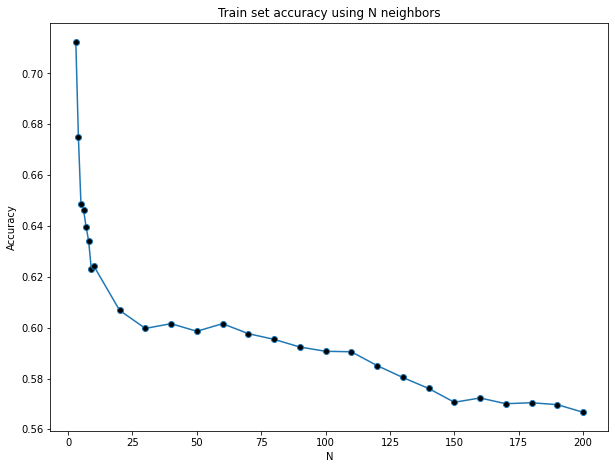

In [ ]:
plt.figure(figsize=(10, 7.5));
plt.title("Train set accuracy using N neighbors");
plt.ylabel("Accuracy");
plt.xlabel("N")
plt.plot(N_vals, accuracies, marker='o', markerfacecolor='black');

In [ ]:
N_vals = np.concatenate((np.arange(3, 10, 1), np.arange(10, 210, 10)))
accuracies = []
for n in N_vals:
  neigh = KNeighborsClassifier(n_neighbors=n)
  neigh.fit(X_train, y_train)

  y_predicted = neigh.predict(X_test)
  knn_accuracy = accuracy_score(y_test, y_predicted)
  accuracies.append(knn_accuracy)

  print("N:", n, "Accuracy:", round(100 * knn_accuracy, 2))

N: 3 Accuracy: 48.05
N: 4 Accuracy: 49.06
N: 5 Accuracy: 50.42
N: 6 Accuracy: 50.46
N: 7 Accuracy: 50.46
N: 8 Accuracy: 50.37
N: 9 Accuracy: 51.29
N: 10 Accuracy: 51.2
N: 20 Accuracy: 53.13
N: 30 Accuracy: 54.57
N: 40 Accuracy: 54.61
N: 50 Accuracy: 53.83
N: 60 Accuracy: 54.7
N: 70 Accuracy: 55.01
N: 80 Accuracy: 54.83
N: 90 Accuracy: 55.18
N: 100 Accuracy: 56.06
N: 110 Accuracy: 55.79
N: 120 Accuracy: 55.31
N: 130 Accuracy: 55.49
N: 140 Accuracy: 54.7
N: 150 Accuracy: 55.05
N: 160 Accuracy: 54.74
N: 170 Accuracy: 54.66
N: 180 Accuracy: 54.83
N: 190 Accuracy: 54.79
N: 200 Accuracy: 54.74


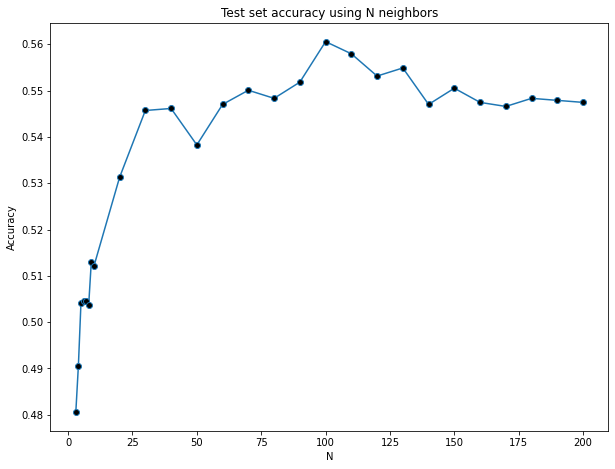

In [ ]:
plt.figure(figsize=(10, 7.5));
plt.title("Test set accuracy using N neighbors");
plt.ylabel("Accuracy");
plt.xlabel("N")
plt.plot(N_vals, accuracies, marker='o', markerfacecolor='black');

In [ ]:
best_neigh = KNeighborsClassifier(n_neighbors=30).fit(X_train, y_train)
y_train_pred = best_neigh.predict(X_train)
y_pred = best_neigh.predict(X_test)

#Analysis of KNN model

In [ ]:
training_accuracy = accuracy_score(y_train, y_train_pred) * 100
print("Training accuracy:", round(training_accuracy, 2))

hiphop_mask = y_test['Genre'] == 0
hiphop_accuracy = accuracy_score(y_pred[hiphop_mask], [0] * sum(hiphop_mask)) * 100
print("Accuracy of Hip Hop:", round(hiphop_accuracy, 2))

pop_mask = y_test['Genre'] == 1
pop_accuracy = accuracy_score(y_pred[pop_mask], [1] * sum(pop_mask)) * 100
print("Accuracy of Pop:", round(pop_accuracy, 2))

rock_mask = y_test['Genre'] == 2
rock_accuracy = accuracy_score(y_pred[rock_mask], [2] * sum(rock_mask)) * 100
print("Accuracy of Rock:", round(rock_accuracy, 2))

overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall accuracy:", round(overall_accuracy, 2))

Training accuracy: 59.97
Accuracy of Hip Hop: 71.9
Accuracy of Pop: 65.67
Accuracy of Rock: 22.24
Overall accuracy: 54.57


# Trying Unknown Songs

In [ ]:
pred = best_neigh.predict(hiphop_test_df2)
print("Predictions (correct label is 0):", pred)
print("Accuracy:", round(accuracy_score(pred, [0] * len(pred)), 2))

Predictions (correct label is 0): [0 0 0]
Accuracy: 1.0


In [ ]:
pred = best_neigh.predict(pop_test_df2)
print("Predictions (correct label is 0):", pred)
print("Accuracy:", round(accuracy_score(pred, [1] * len(pred)), 2))

Predictions (correct label is 0): [1 1 0]
Accuracy: 0.67


In [ ]:
pred = best_neigh.predict(rock_test_df2)
print("Predictions (correct label is 0):", pred)
print("Accuracy:", round(accuracy_score(pred, [2] * len(pred)), 2))

Predictions (correct label is 0): [2 2 1]
Accuracy: 0.67


#END